In [1]:
%load_ext autoreload

In [2]:
%autoreload
import os
import numpy as np
import pandas as pd
import time
import pickle
from tqdm.notebook import tqdm
from numpy.lib.format import open_memmap
from pandarallel import pandarallel
from scipy.stats import multivariate_normal, entropy
from scripts.data import *
from scripts.preprocessing import *
from scripts.utils import *
from scripts.main import *
from scripts.saliency_metrics import *

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

In [3]:
# data path where each subject forlder is 
data_path    = './../data/ETFinalCutSampleEC07/ETFinalCutSample/'
results_path = './../results/'

In [4]:
trials_data = load_trials_data()
trials_data.head(3)

FilePath  \
ID           Video_ID                                                      
NDARAA075AMK Video1    /Volumes/methlab_data/HBN/EEG-ET/NDARAA075AMK/...   
             Video3    /Volumes/methlab_data/HBN/EEG-ET/NDARAA075AMK/...   
NDARAA117NEJ Video1    /Volumes/methlab_data/HBN/EEG-ET/NDARAA117NEJ/...   

                        VideoName  SRate       Start          Stop  \
ID           Video_ID                                                
NDARAA075AMK Video1         Diary     60  2887191440  3.004585e+09   
             Video3    Despicable     60  3788400246  3.958946e+09   
NDARAA117NEJ Video1         Diary     60  3333897971  3.451293e+09   

                          Duration  
ID           Video_ID               
NDARAA075AMK Video1    117393138.0  
             Video3    170545550.0  
NDARAA117NEJ Video1    117395130.0

In [5]:
videos_data = load_video_data()
videos_data

,Video,Duration(s),NFrames,FPS,Resolution,Width,Height,FramesTimestamps,VideoSaliency,VideoSaliencyNOcb,VideoSalPercentils,VideoSalPercentilsNOcb,Short Name
VideoName,,,,,,,,,,,,,
Diary,Diary_of_a_Wimpy_Kid_Trailer.mp4,117,2817.0,24.0,"(346, 640)",640.0,346.0,"[0.0, 41.708333333333336, 83.41666666666667, 1...",Diary_of_a_Wimpy_Kid_Trailer_saliency_cb.npy,Diary_of_a_Wimpy_Kid_Trailer_saliency.npy,Diary_of_a_Wimpy_Kid_Trailer_saliency_cb_perce...,Diary_of_a_Wimpy_Kid_Trailer_saliency_percenti...,WK
Fractals,Fun_Fractals_v2.mp4,274,8220.0,30.0,"(360, 640)",640.0,360.0,"[0.0, 33.36666666666667, 66.73333333333333, 10...",Fun_Fractals_v2_saliency_cb.npy,Fun_Fractals_v2_saliency.npy,Fun_Fractals_v2_saliency_cb_percentils.npy,Fun_Fractals_v2_saliency_percentils.npy,FF
Present,The Present_Short.mp4,203,4877.0,24.0,"(720, 1280)",1280.0,720.0,"[0.0, 41.666666666666664, 83.33333333333333, 1...",The Present_Short_saliency_cb.npy,The Present_Short_saliency.npy,The Present_Short_saliency_cb_percentils.npy,The Present_Short_saliency_percentils.npy,TP
Despicable,Three_Little_Kittens_Despicable_Me.mp4,170,4266.0,25.0,"(336, 624)",624.0,336.0,"[0.0, 40.0, 80.0, 120.0, 160.0, 200.0, 240.0, ...",Three_Little_Kittens_Despicable_Me_saliency_cb...,Three_Little_Kittens_Despicable_Me_saliency.npy,Three_Little_Kittens_Despicable_Me_saliency_cb...,Three_Little_Kittens_Despicable_Me_saliency_pe...,DM


In [6]:
metadata = load_metadata()
metadata.sample(3)

,Age,ID,Enroll_Season,Enroll_Year,Release_Number,Sex,CV_Score,med_type_01,med_type_02,med_type_03,...,Site,EHQ_Total,Child_Race,SWAN_HY,SWAN_IN,SWAN_Total,WAIS_FSIQ_SCALE,WASI_FSIQ,WISC_FSIQ,SWAN
3220,10.394022,NDARYA496WZD,Fall,2016,1,0,14,.,.,.,...,1,100,.,1.777777,1.333333,1.555555,.,.,105,1.555555
226,9.690965,NDARBK106KRH,Fall,2018,7,0,14,.,.,.,...,4,86.67,0,-1.666666,-1.555555,-1.611111,.,.,115,-1.611111
3399,17.419917,NDARZC497BFU,Summer,2018,6,0,NaN,.,.,.,...,3,.,0,0,0,0,100,NaN,.,0.000000


***
## AUC

In [7]:
saliency_path = './../videos_sal/deepgaze/'
percentils_path = './../cache/'

In [8]:
vid_name = 'Diary'
trials_data_vid = trials_data[trials_data.VideoName==vid_name]

saliency       = open_memmap(os.path.join(saliency_path, videos_data.loc[vid_name, 'VideoSaliency']))
sal_perc       = np.load(os.path.join(percentils_path, videos_data.loc[vid_name, 'VideoSalPercentils']))

missing_folders  = []
missing_csv_vid  = []
missing_metadata = []
results          = []

n_subj     = len(trials_data_vid)
subj_count = 0

for fold_subj in tqdm(os.listdir(data_path)):
    if fold_subj in list(metadata['ID'].unique()):
        pass
    else:
        missing_metadata.append(fold_subj)
        continue
        
    csv_files    = os.listdir(data_path+fold_subj)
    csv_vid_file = [f for f in csv_files if 'WK' in f]
    if len(csv_vid_file) ==0:
        missing_csv_vid.append(fold_subj)
        continue
        
    et_file      = data_path + fold_subj + '/' + csv_vid_file[0]
    df_et        = pd.read_csv(et_file)
    frame_timest = videos_data.loc[vid_name,'FramesTimestamps']
    trial_init   = trials_data.loc[fold_subj].set_index('VideoName').loc[vid_name].Start
    df_fix, flag = preprocess_fixations_new_dataset(df_et, frame_timest, trial_init)
    break
    if flag==-1:
        continue
    else:
        auc_score, tpr = fixations_subj_auc(df_fix, vid_saliency = saliency, vid_saliency_percentils = sal_perc,
                                                trial_resol_width=800, trial_resol_hight=600, npercentils=21)
    
    results.append((fold_subj, auc_score, len(df_fix), flag, vid_name, et_file, tpr))

  0%|          | 0/1758 [00:00<?, ?it/s]

In [9]:
df_fix.start_time.iloc[0],df_fix.end_time.iloc[0], df_fix.frames_seen.iloc[0]

(286.143999999855, 436.277000000235, array([ 7,  8,  9, 10]))

In [10]:
len(df_fix.x.iloc[0])

18

In [11]:
df_fix.head()

,fix,x,y,subId,trialId,event_len,start_time,end_time,dur,x_mean,y_mean,x_std,y_std,sample_timestamps,frames_seen
2,1,"[453.24, 442.07, 445.2, 435.77, 430.88, 434.95...","[239.84, 239.22, 238.79, 236.44, 236.75, 237.5...",0,0,18,286.144,436.277,150.133,435.777778,239.205556,5.779414,1.534308,"[286.143999999855, 294.48472222209836, 302.825...","[7, 8, 9, 10]"
4,1,"[265.15, 244.62, 247.48, 244.22, 240.22, 240.6...","[237.13, 236.56, 235.85, 235.16, 235.29, 235.1...",0,0,23,452.890,644.797,191.907,241.332174,232.651304,5.551998,3.621135,"[452.89000000013, 461.233782608831, 469.577565...","[11, 12, 13, 14, 15]"
6,1,"[235.66, 233.67, 231.38, 229.08, 227.73, 226.4...","[222.07, 220.63, 219.67, 218.64, 217.44, 216.1...",0,0,10,653.148,736.541,83.393,230.147000,217.018000,6.166529,3.031171,"[653.148000000045, 661.4873000000606, 669.8266...","[16, 17]"
8,1,"[308.53, 325.21, 328.89, 331.04, 333.1, 333.7,...","[212.12, 212.55, 212.57, 212.56, 212.82, 213.9...",0,0,28,744.893,978.405,233.512,338.341429,214.277500,7.817132,0.896759,"[744.893000000156, 753.2327142858741, 761.5724...","[18, 19, 20, 21, 22, 23]"
10,1,"[487.59, 498.51, 502.33, 502.43, 503.78, 504.1...","[218.86, 219.5, 220.63, 221.52, 221.92, 222.12...",0,0,20,1003.535,1170.265,166.730,506.316000,224.636500,6.075180,3.398241,"[1003.53500000015, 1011.871500000149, 1020.208...","[25, 26, 27, 28]"


***

## NSS DeepGaze

In [12]:
def create_saliency_matrix(video_path, saliency_path ='../videos_sal/vinet'):
    folder = video_path #videos_data.loc[video].Video[:-4]
    maps = []
    for img in sorted(os.listdir(os.path.join(saliency_path, folder))):
        if img[0] == '.':
            continue
        maps.append(cv2.imread(os.path.join(saliency_path, folder, img), cv2.IMREAD_GRAYSCALE))
    return np.stack(maps, axis=2)

In [ ]:
def calculate_metric(data_path, trials_data, videos_data, vid_name = 'Diary', saliency = None, metric = 'NSS', saliency_path = ''):
    
    trials_data_vid = trials_data[trials_data.VideoName==vid_name]
    frame_dur = (videos_data.loc[vid_name].FramesTimestamps[1])
    vid = {'Diary': 'WK', 'Fractals': 'FF', 'Present': 'TP'}

    # vid_saliency   = videos_data.loc[vid_name, 'VideoSaliency']
    # vid_saliency_p = videos_data.loc[vid_name, 'VideoSalPercentils']
    # saliency       = open_memmap('Videos_sal/cb/'+vid_saliency)
    # sal_perc       = np.load('./cache/'+vid_saliency_p)
    
    if saliency is None:
        #saliency = open_memmap(os.path.join(saliency_path, videos_data.loc[vid_name, 'VideoSaliency']))
        saliency = create_saliency_matrix(videos_data.loc[vid_name].Video[:-4], saliency_path=saliency_path)
        
    missing_folders  = []
    video_not_seen   = []
    missing_metadata = []
    results          = []

    n_subj     = len(trials_data_vid)
    subj_count = 0
    
    aux = sorted(os.listdir(data_path))
    corte = int(len(aux)//6)
    iter_list = aux[:corte]
    for fold_subj in tqdm(iter_list):
        if fold_subj in list(metadata['ID'].unique()):
            pass
        else:
            missing_metadata.append(fold_subj)
            continue

        csv_files    = os.listdir(data_path+fold_subj)
        csv_vid_file = [f for f in csv_files if vid[vid_name] in f]
        if len(csv_vid_file) ==0:
            video_not_seen.append(fold_subj)
            continue

        et_file      = os.path.join(data_path, fold_subj, csv_vid_file[0])
        df_et        = pd.read_csv(et_file)
        frame_timest = videos_data.loc[vid_name,'FramesTimestamps']
        try:
            trial_init   = trials_data.loc[fold_subj].set_index('VideoName').loc[vid_name].Start
        except:
            missing_metadata.append([fold_subj, vid_name])
            continue
        
        df_fix, flag = preprocess_fixations_new_dataset(df_et, frame_timest, trial_init, sdt_correction = False)
        # drop fixations after video ended
        df_fix = df_fix[df_fix['start_time']//frame_dur < saliency.shape[-1]]
        print(fold_subj)
        if flag==-1:
            continue
        elif metric =='CC':
            score = calculate_CC_apply(df_fix, saliency)
        elif metric=='NSS':
            score = calculate_NSS(df_fix, saliency, frame_dur)
        else:
            print('Metric not implemented')
            break
            
        mean_score = np.mean(np.array(score))
        results.append((fold_subj,  df_fix.index, score, mean_score, len(df_fix), flag, vid_name, et_file))
        #results_nss.append((fold_subj, nss_mean_score, len(df_fix), flag, vid_name, et_file, nss_score))
    return results, {'missing_folders': missing_folders, 'missing_metadata': missing_metadata, 'video_not_seen': video_not_seen}

In [ ]:
def calculate_metric_subject(df_et, trials_data, videos_data, vid_name, saliency, metric, trial_init=None, frame_dur=None, frame_timest=None):
    
    if not frame_dur:
        frame_dur = (videos_data.loc[vid_name].FramesTimestamps[1])
    if not trial_init:
        trial_init   = trials_data.loc[fold_subj].set_index('VideoName').loc[vid_name].Start
    if not frame_timest:
        frame_timest = videos_data.loc[vid_name,'FramesTimestamps']
    
    df_fix, flag = preprocess_fixations_new_dataset(df_et, frame_timest, trial_init, sdt_correction = False)
    # drop fixations after video ended
    df_fix = df_fix[df_fix['start_time']//frame_dur < saliency.shape[-1]]
    print(fold_subj)
    if flag==-1:
        pass
    elif metric =='CC':
        score = calculate_CC_apply(df_fix, saliency)
    elif metric=='NSS':
        score = calculate_NSS(df_fix, saliency, frame_dur)
    else:
        print('Metric not implemented')
        pass
    
    mean_score = np.mean(np.array(score))

    return df_fix, score, mean_score, flag

In [13]:
def calculate_metric_chunks(data_path, trials_data, videos_data, n_chunks:int, chunk_i:int, vid_name = 'Diary', saliency = None, metric = 'NSS', saliency_path = ''):
    
    trials_data_vid = trials_data[trials_data.VideoName==vid_name]
    frame_dur = (videos_data.loc[vid_name].FramesTimestamps[1])
    vid = {'Diary': 'WK', 'Fractals': 'FF', 'Present': 'TP'}

    # vid_saliency   = videos_data.loc[vid_name, 'VideoSaliency']
    # vid_saliency_p = videos_data.loc[vid_name, 'VideoSalPercentils']
    # saliency       = open_memmap('Videos_sal/cb/'+vid_saliency)
    # sal_perc       = np.load('./cache/'+vid_saliency_p)
    
    if saliency is None:
        #saliency = open_memmap(os.path.join(saliency_path, videos_data.loc[vid_name, 'VideoSaliency']))
        saliency = create_saliency_matrix(videos_data.loc[vid_name].Video[:-4], saliency_path=saliency_path)
        
    missing_folders  = []
    video_not_seen   = []
    missing_metadata = []
    results          = []
    error_list       = []

    n_subj     = len(trials_data_vid)
    subj_count = 0
    
    # calculate chunk
    aux = sorted(os.listdir(data_path))
    corte = int(len(aux)//n_chunks)
    if chunk_i == n_chunks-1:
        iter_list = aux[chunk_i * corte:]
    else:
        iter_list = aux[chunk_i * corte:(chunk_i+1)*corte]
    
    for fold_subj in tqdm(iter_list):
        
        if fold_subj not in list(metadata['ID'].unique()):
            missing_metadata.append(fold_subj)
            continue
        
        csv_files    = os.listdir(data_path+fold_subj)
        csv_vid_file = [f for f in csv_files if vid[vid_name] in f]
        if len(csv_vid_file) ==0:
            video_not_seen.append(fold_subj)
            continue

        et_file      = os.path.join(data_path, fold_subj, csv_vid_file[0])
        df_et        = pd.read_csv(et_file)
        frame_timest = videos_data.loc[vid_name,'FramesTimestamps']
        
        try:
            trial_init   = trials_data.loc[fold_subj].set_index('VideoName').loc[vid_name].Start
        except:
            missing_metadata.append([fold_subj, vid_name])
            continue
            
        # calculate metric
        try:
            df_fix, score, mean_score, flag = calculate_metric_subject(df_et, trials_data, videos_data, vid_name, saliency, metric, trial_init, frame_dur, frame_timest)
            results.append((fold_subj,  df_fix.index, score, mean_score, len(df_fix), flag, vid_name, et_file))
        except:
            error_list.append(fold_subj)
        
    return results, {'missing_folders': missing_folders, 'missing_metadata': missing_metadata, 'video_not_seen': video_not_seen}

In [14]:
# add frame idx
def add_frame_idx(df, vid_name, data_path, trials_data, videos_data):
    dfs_list = []
    for idx in df.ID.unique():
    
        df_aux       = df[df.ID==idx].copy()
        et_file      = df_aux.ET_FILE.iloc[0]
        df_et        = pd.read_csv(os.path.join(data_path,et_file[2:]))
        frame_timest = videos_data.loc[vid_name,'FramesTimestamps']
        trial_init   = trials_data.loc[idx].set_index('VideoName').loc[vid_name].Start
        df_fix, flag = preprocess_fixations_new_dataset(df_et, frame_timest, trial_init)
        frame_id     = df_fix.frames_seen.apply(lambda x: x[0])
        #print(frame_id.columns)
        #print(frame_id.index)
        df_aux       = df_aux.merge(frame_id,how='right',left_on='FIX_idx',right_index=True)    
        dfs_list.append(df_aux)
        
    df_exploded_frames = pd.concat(dfs_list)
    df_exploded_frames.rename({'frames_seen':'FRAME_idx'}, axis=1, inplace=True)
    
    return df_exploded_frames

In [15]:
trials_data.head()#index.droplevel(1).unique()

FilePath  \
ID           Video_ID                                                      
NDARAA075AMK Video1    /Volumes/methlab_data/HBN/EEG-ET/NDARAA075AMK/...   
             Video3    /Volumes/methlab_data/HBN/EEG-ET/NDARAA075AMK/...   
NDARAA117NEJ Video1    /Volumes/methlab_data/HBN/EEG-ET/NDARAA117NEJ/...   
             Video3    /Volumes/methlab_data/HBN/EEG-ET/NDARAA117NEJ/...   
NDARAA306NT2 Video-DM  /Volumes/methlab_data/HBN/EEG-ET/NDARAA306NT2/...   

                        VideoName  SRate       Start          Stop  \
ID           Video_ID                                                
NDARAA075AMK Video1         Diary     60  2887191440  3.004585e+09   
             Video3    Despicable     60  3788400246  3.958946e+09   
NDARAA117NEJ Video1         Diary     60  3333897971  3.451293e+09   
             Video3    Despicable     60  4710198376  4.880739e+09   
NDARAA306NT2 Video-DM  Despicable     60  3125258026  3.295796e+09   

                          Duration  
ID           Video_ID               
NDARAA075AMK Video1    117393138.0  
             Video3    170545550.0  
NDARAA117NEJ Video1    117395130.0  
             Video3    170540748.0  
NDARAA306NT2 Video-DM  170537702.0

### Diary

<AxesSubplot:>

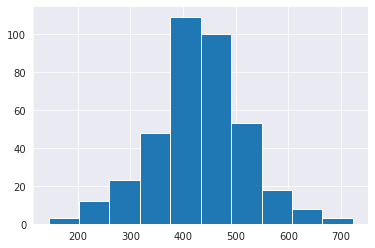

In [16]:
df_fix.x.apply(max).hist()

In [17]:
saliency.shape

(346, 640, 2817)

In [18]:
results_nss_diary = calculate_metric(data_path, trials_data, videos_data, vid_name = 'Fractals', saliency_path='./../videos_sal/vinet/')

  0%|          | 0/293 [00:00<?, ?it/s]

NDARAB055BPR
NDARAB348EWR
NDARAB793GL3
NDARAC857HDB
NDARAD224CRB
NDARAD615WLJ
NDARAE866UVF
NDARAG584XLU
NDARAH304ED7
NDARAH793FBF
NDARAJ689BVN
NDARAK653RYE
NDARAM048AFP
NDARAM848GTE
NDARAN076TPG
NDARAN461TGQ
NDARAN524ZK6
NDARAP522AFK
NDARAP782TVC
NDARAP785CTE
NDARAR238RZ8
NDARAT244VGA
NDARAT358XM9
NDARAU530GLJ
NDARAU708TL8
NDARAV189JGX
NDARAW179AYF
NDARAX358NB5
NDARAX887JRN
NDARAY283AU1
NDARBA381JGH
NDARBA507GCT
NDARBC240LNC
NDARBC580HR5
NDARBD879MBX
NDARBE091BGD
NDARBE103DHM
NDARBF183RFB
NDARBF851NH6
NDARBG188RA5
NDARBH992ARB
NDARBJ159HXB
NDARBJ375VP4
NDARBJ637CFZ
NDARBJ674TVU
NDARBK638HLZ
NDARBL532FPT
NDARBL935ZUA
NDARBM433VER
NDARBM642JFT
NDARBR128UFP
NDARBT747UHM
NDARBU098PJT
NDARBU532YXZ
NDARBV059CGE
NDARBV167RMU
NDARBV630BK6
NDARBW026UGE
NDARBW255JE1
NDARBW525JHY
NDARBX974XDR
NDARBZ475NKK
NDARBZ913ZB9
NDARBZ925PRF
NDARCA578CEB
NDARCC140AAK
NDARCC340ER5
NDARCC824FCL
NDARCD296XU9
NDARCD543VK6
NDARCD661GL0
NDARCE721YB5
NDARCF052AE0
NDARCG258NEF
NDARCG438NML
NDARCG785NND
NDARCG947ZC0

In [19]:
len(results_nss_diary[1]['video_not_seen'])

140

In [20]:
pd.DataFrame(results_nss_diary[0]).head()

,0,1,2,3,4,5,6,7
0,NDARAB055BPR,"Int64Index([ 1, 3, 5, 7, 9, 11...","[-0.38542647295516763, -0.3957200964771436, 5....",2.830033,538,0,Fractals,./../data/ETFinalCutSampleEC07/ETFinalCutSampl...
1,NDARAB348EWR,"Int64Index([ 1, 3, 5, 7, 9, 11...","[-0.4177379349809336, -0.4083017949260995, -0....",1.146939,550,0,Fractals,./../data/ETFinalCutSampleEC07/ETFinalCutSampl...
2,NDARAB793GL3,"Int64Index([ 1, 3, 5, 7, 9, 11...","[5.243389030228941, 5.434201899179609, 4.63233...",2.040553,725,0,Fractals,./../data/ETFinalCutSampleEC07/ETFinalCutSampl...
3,NDARAC857HDB,"Int64Index([ 1, 3, 5, 7, 9, 11, 13,...","[3.785618607121861, 3.1063377194712745, 1.6036...",2.307955,391,0,Fractals,./../data/ETFinalCutSampleEC07/ETFinalCutSampl...
4,NDARAD224CRB,"Int64Index([ 1, 3, 5, 7, 8, 11...","[0.3022251704596166, 1.2886255047375095, 6.940...",2.917189,597,0,Fractals,./../data/ETFinalCutSampleEC07/ETFinalCutSampl...


In [21]:
df_nss_diary_aux = pd.DataFrame(results_nss_diary[0])
df_nss_diary_aux.columns = ['ID', 'FIX_idx', 'NSS','NSS_MEAN', 'FIX_IN_VID', 'FLAG', 'VIDEO_NAME', 'ET_FILE']
df_nss_diary_exploded = explode(df_nss_diary_aux, ['FIX_idx','NSS'])
df_wk_final = add_frame_idx(df_nss_diary_exploded.reset_index(), vid_name = 'Fractals', data_path='./', trials_data=trials_data, videos_data=videos_data)
df_wk_final.shape

(83108, 10)

In [22]:
df_wk_final.head()

,index,ID,FIX_idx,NSS,NSS_MEAN,FIX_IN_VID,FLAG,VIDEO_NAME,ET_FILE,FRAME_idx
0,0,NDARAB055BPR,1,-0.385426,2.830033,538,0,Fractals,./../data/ETFinalCutSampleEC07/ETFinalCutSampl...,5
1,1,NDARAB055BPR,3,-0.395720,2.830033,538,0,Fractals,./../data/ETFinalCutSampleEC07/ETFinalCutSampl...,12
2,2,NDARAB055BPR,5,5.679343,2.830033,538,0,Fractals,./../data/ETFinalCutSampleEC07/ETFinalCutSampl...,17
3,3,NDARAB055BPR,7,4.140309,2.830033,538,0,Fractals,./../data/ETFinalCutSampleEC07/ETFinalCutSampl...,22
4,4,NDARAB055BPR,9,2.893168,2.830033,538,0,Fractals,./../data/ETFinalCutSampleEC07/ETFinalCutSampl...,24


In [23]:
results_path = './../results/revised/'
df_wk_final.drop(columns=['index', 'FLAG']).to_csv(os.path.join(results_path, 'FF', 'results_nss_ff_vn_1.csv'), index=False)


In [24]:
results_path = './../results/revised/'
df_wk_final.drop(columns=['index', 'FLAG']).to_csv(os.path.join(results_path, 'FF', 'results_nss_ff_vn_1.csv'), index=False)

import json

with open(os.path.join(results_path, 'FF', 'dump_nss_ff_vn_1.json'), 'w') as jf:
    json.dump(results_nss_diary[1], jf)

<AxesSubplot:>

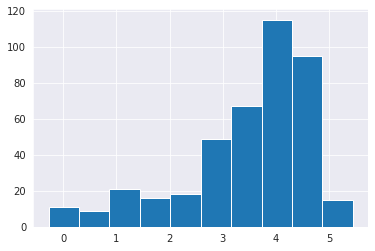

In [52]:
df_wk_final.drop_duplicates('ID').NSS_MEAN.hist()

Using other window

### Present

In [15]:
results_nss_present = calculate_metric(data_path, trials_data, videos_data, vid_name = 'Present', saliency_path='./../videos_sal/deepgaze/')

  0%|          | 0/994 [00:00<?, ?it/s]

In [16]:
pd.DataFrame(results_nss_present[0])[3].mean()

1.3559091137840023

In [17]:
len(results_nss_present[1]['video_not_seen'])

753

In [18]:
pd.DataFrame(results_nss_present[0]).shape

(237, 8)

In [31]:
df_nss_present = pd.DataFrame(results_nss_present[0])
df_nss_present.columns = ['ID', 'FIX_idx', 'NSS','NSS_MEAN', 'FIX_IN_VID', 'FLAG', 'VIDEO_NAME', 'ET_FILE']
df_nss_present_exploded = explode(df_nss_present, ['FIX_idx','NSS'])
df_tp_final = add_frame_idx(df_nss_present_exploded.reset_index(), vid_name = 'Present', data_path='./', trials_data=trials_data, videos_data=videos_data)
df_tp_final.shape

(154614, 10)

In [42]:
df_tp_final.drop(columns=['index']).head()

,ID,FIX_idx,NSS,NSS_MEAN,FIX_IN_VID,FLAG,VIDEO_NAME,ET_FILE,FRAME_idx
0,NDARVB819ENX,1,-0.955203,1.8578,527,0,Present,./../data/ETFinalCutSampleEC07/ETFinalCutSampl...,2
1,NDARVB819ENX,4,-0.018449,1.8578,527,0,Present,./../data/ETFinalCutSampleEC07/ETFinalCutSampl...,11
2,NDARVB819ENX,6,-0.354813,1.8578,527,0,Present,./../data/ETFinalCutSampleEC07/ETFinalCutSampl...,14
3,NDARVB819ENX,8,-0.342154,1.8578,527,0,Present,./../data/ETFinalCutSampleEC07/ETFinalCutSampl...,17
4,NDARVB819ENX,10,6.080756,1.8578,527,0,Present,./../data/ETFinalCutSampleEC07/ETFinalCutSampl...,22


In [48]:
df_tp_final.drop(columns=['index']).to_csv(os.path.join(results_path, 'TP', 'results_nss_tp_dg.csv'), index=False)

### Fractals

In [19]:
results_nss_fractals = calculate_metric(data_path, trials_data, videos_data, vid_name = 'Fractals', saliency_path='./../videos_sal/deepgaze/')

  0%|          | 0/994 [00:00<?, ?it/s]

In [20]:
pd.DataFrame(results_nss_fractals[0])[3].mean()

1.2365694818860393

In [21]:
len(results_nss_fractals[1]['video_not_seen'])

813

In [33]:
df_nss_fractals = pd.DataFrame(results_nss_fractals[0])
df_nss_fractals.columns = ['ID', 'FIX_idx', 'NSS','NSS_MEAN', 'FIX_IN_VID', 'FLAG', 'VIDEO_NAME', 'ET_FILE']
df_nss_fractals_exploded = explode(df_nss_fractals, ['FIX_idx','NSS'])
df_ff_final = add_frame_idx(df_nss_fractals_exploded.reset_index(), vid_name = 'Fractals', data_path='./', trials_data=trials_data, videos_data=videos_data)
df_ff_final.shape

(88877, 10)

In [49]:
df_ff_final.drop(columns=['index']).to_csv(os.path.join(results_path, 'FF', 'results_nss_ff_dg.csv'), index=False)

### Checking ids

In [36]:
def dummy_check_data_path(data_path):

    file_count = dict()
    file_ids   = dict()
    file_out   = dict()
    for vid in ['WK', 'TP', 'FF']:
        err = []
        ids = []
        for fold in os.listdir(data_path):
            try:
                csv_files    = os.listdir(data_path+fold)
            except NotADirectoryError:
                continue

            csv_vid_file = [f for f in csv_files if vid in f]
            if len(csv_vid_file)==0:
                err.append(fold)
            else:
                ids.append(fold)
                

        file_ids[vid]   = ids
        file_out[vid]   = err
        file_count[vid] = len(err)
        
    return file_ids, file_out, file_count

In [38]:
tmp = dummy_check_data_path(data_path)

In [39]:
alternative_data_path = './../data/ETFinalCutSample/'
tmp2 = dummy_check_data_path(alternative_data_path)

### Check exclusion criteria

In [9]:
df_checks = pd.read_csv('./../data/QualityControlSummary.csv').set_index('ID')

## NSS ViNet

In [7]:
def create_saliency_matrix(video, videos_data, vinet_path ='../videos_sal/vinet'):
    folder = videos_data.loc[video].Video[:-4]
    maps = []
    for img in sorted(os.listdir(os.path.join(vinet_path, folder))):
        maps.append(cv2.imread(os.path.join(vinet_path, folder, img), cv2.IMREAD_GRAYSCALE))
    return np.stack(maps, axis=2)

### Diary

In [8]:
saliency_diary = create_saliency_matrix('Diary', videos_data)

ValueError: all input arrays must have the same shape

In [71]:
# prueba
results_nss_diary = calculate_metric(data_path, trials_data, videos_data, vid_name = 'Diary', saliency = saliency_diary)

  0%|          | 0/764 [00:00<?, ?it/s]

In [89]:
df_nss_diary = pd.DataFrame(results_nss_diary[0])
df_nss_diary.columns = ['ID', 'FIX_idx', 'NSS','NSS_MEAN', 'FIX_IN_VID', 'FLAG', 'VIDEO_NAME', 'ET_FILE']
df_nss_diary_exploded = explode(df_nss_diary, ['FIX_idx','NSS'])
df_nss_diary_exploded.shape

(325877, 8)

### Present

In [13]:
saliency_present = create_saliency_matrix('Present', videos_data)

In [73]:
results_nss_present = calculate_metric(data_path, trials_data, videos_data, vid_name = 'Present', saliency = saliency_present)

  0%|          | 0/764 [00:00<?, ?it/s]

In [90]:
df_nss_present = pd.DataFrame(results_nss_present[0])
df_nss_present.columns = ['ID','FIX_idx', 'NSS', 'NSS_MEAN', 'FIX_IN_VID', 'FLAG', 'VIDEO_NAME', 'ET_FILE']
df_nss_present_exploded = explode(df_nss_present, ['FIX_idx','NSS'])
df_nss_present_exploded.shape

(527907, 8)

### Fractals

In [15]:
saliency_fractals = create_saliency_matrix('Fractals', videos_data)

In [75]:
results_nss_fractals = calculate_metric(data_path, trials_data, videos_data, vid_name = 'Fractals', saliency = saliency_fractals)

  0%|          | 0/764 [00:00<?, ?it/s]

In [85]:
df_nss_fractals = pd.DataFrame(results_nss_fractals[0])
df_nss_fractals.columns = ['ID', 'FIX_idx', 'NSS', 'NSS_MEAN', 'FIX_IN_VID', 'FLAG', 'VIDEO_NAME', 'ET_FILE']
df_nss_fractals_exploded = explode(df_nss_fractals, ['FIX_idx','NSS'])
df_nss_fractals_exploded.shape

(416045, 8)

### Adding frames

In [113]:
df_tp_final = add_frame_idx(df_nss_present_exploded.reset_index(), vid_name = 'Present', data_path='./', trials_data=trials_data, videos_data=videos_data)
df_ff_final = add_frame_idx(df_nss_fractals_exploded.reset_index(), vid_name = 'Fractals', data_path='./', trials_data=trials_data, videos_data=videos_data)
df_wk_final = add_frame_idx(df_nss_diary_exploded.reset_index(), vid_name = 'Diary', data_path='./', trials_data=trials_data, videos_data=videos_data)

In [114]:
df_tp_final.drop(columns=['index'])

,ID,FIX_idx,NSS,NSS_MEAN,FIX_IN_VID,FLAG,VIDEO_NAME,ET_FILE,FRAME_idx
0,NDARGX173AC3,1,1.632614,1.664862,708,0,Present,./../data/ETFinalCutSample/NDARGX173AC3/NDARGX...,3
1,NDARGX173AC3,3,-0.120065,1.664862,708,0,Present,./../data/ETFinalCutSample/NDARGX173AC3/NDARGX...,9
2,NDARGX173AC3,5,-0.404257,1.664862,708,0,Present,./../data/ETFinalCutSample/NDARGX173AC3/NDARGX...,14
3,NDARGX173AC3,7,-0.415283,1.664862,708,0,Present,./../data/ETFinalCutSample/NDARGX173AC3/NDARGX...,16
4,NDARGX173AC3,9,2.906565,1.664862,708,0,Present,./../data/ETFinalCutSample/NDARGX173AC3/NDARGX...,32
...,...,...,...,...,...,...,...,...,...
527902,NDARGC559LN8,1093,0.377692,1.105855,550,0,Present,./../data/ETFinalCutSample/NDARGC559LN8/NDARGC...,4835
527903,NDARGC559LN8,1095,-0.089380,1.105855,550,0,Present,./../data/ETFinalCutSample/NDARGC559LN8/NDARGC...,4844
527904,NDARGC559LN8,1097,-0.144578,1.105855,550,0,Present,./../data/ETFinalCutSample/NDARGC559LN8/NDARGC...,4849
527905,NDARGC559LN8,1100,0.535246,1.105855,550,0,Present,./../data/ETFinalCutSample/NDARGC559LN8/NDARGC...,4860


In [117]:
load_subj_et_data('NDARGX173AC3', video_id='TP', data_path = './../data/ETFinalCutSample/')

,fix,x,y,subId,trialId,event_len,start_time,end_time
0,0,"[438.94, 305.29, 170.39, 141.72, 302.51, 219.9...","[171.3, 189.95, 378.0, 425.31, 357.06, 374.12,...",0,0,14,6.932,123.708
1,1,"[205.54, 205.87, 207.08, 199.27, 215.34, 214.8...","[315.62, 312.3, 314.06, 312.58, 307.18, 309.03...",0,0,15,123.708,248.783
2,0,"[222.17, 224.87, 226.87, 226.96, 228.85, 230.5...","[328.37, 326.21, 325.55, 325.99, 323.89, 321.4...",0,0,14,248.783,365.560
3,1,"[585.58, 583.44, 581.74, 581.66, 584.9, 584.67...","[390.46, 389.55, 393.73, 395.74, 397.22, 397.6...",0,0,20,365.560,532.455
4,0,"[604.14, 606.02, 610.05, 616.39]","[409.15, 412.4, 418.44, 426.04]",0,0,4,532.455,565.818
...,...,...,...,...,...,...,...,...
1566,0,[66.87],[325.67],0,0,1,202683.148,202691.536
1567,-1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0,17,202699.901,202841.655
1568,0,"[82.84, 47.51, 47.92, 65.63, 234.18, 326.52, 3...","[437.48, 473.38, 464.29, 435.59, 304.57, 306.4...",0,0,9,202841.655,202916.785
1569,1,"[250.02, 233.43, 237.82, 229.41, 232.48, 227.8...","[302.56, 303.46, 304.52, 305.98, 306.36, 305.9...",0,0,10,202916.785,203000.147


### Save

In [ ]:
df_wk_final.drop(columns=['index']).to_csv(os.path.join(results_path, 'WK', 'results_nss_wk_vn.csv'), index=False)
df_tp_final.drop(columns=['index']).to_csv(os.path.join(results_path, 'TP', 'results_nss_tp_vn.csv'), index=False)
df_ff_final.drop(columns=['index']).to_csv(os.path.join(results_path, 'FF', 'results_nss_ff_vn.csv'), index=False)

## NSS - Spectral saliency

### Diary

In [16]:
saliency_diary = create_saliency_matrix('Diary', videos_data, vinet_path ='../videos_sal/spectral')

In [18]:
results_nss_diary = calculate_metric(data_path, trials_data, videos_data, vid_name = 'Diary', saliency = saliency_diary)

  0%|          | 0/994 [00:00<?, ?it/s]

In [19]:
df_nss_diary = pd.DataFrame(results_nss_diary[0])
df_nss_diary.columns = ['ID', 'FIX_idx', 'NSS','NSS_MEAN', 'FIX_IN_VID', 'FLAG', 'VIDEO_NAME', 'ET_FILE']
df_nss_diary_exploded = explode(df_nss_diary, ['FIX_idx','NSS'])
df_nss_diary_exploded.shape

(363788, 8)

In [20]:
df_wk_final = add_frame_idx(df_nss_diary_exploded.reset_index(), vid_name = 'Diary', data_path='./', trials_data=trials_data, videos_data=videos_data)

In [21]:
df_wk_final.drop(columns=['index']).to_csv(os.path.join(results_path, 'WK', 'results_nss_wk_spectral.csv'), index=False)

### Present

In [22]:
saliency_present = create_saliency_matrix('Present', videos_data, vinet_path ='../videos_sal/spectral')
results_nss_present = calculate_metric(data_path, trials_data, videos_data, vid_name = 'Present', saliency = saliency_present)
df_nss_present = pd.DataFrame(results_nss_present[0])
df_nss_present.columns = ['ID', 'FIX_idx', 'NSS','NSS_MEAN', 'FIX_IN_VID', 'FLAG', 'VIDEO_NAME', 'ET_FILE']
df_nss_present_exploded = explode(df_nss_present, ['FIX_idx','NSS'])
df_nss_present_exploded.shape
df_tp_final = add_frame_idx(df_nss_present_exploded.reset_index(), vid_name = 'Present', data_path='./', trials_data=trials_data, videos_data=videos_data)

  0%|          | 0/994 [00:00<?, ?it/s]

In [23]:
df_tp_final.drop(columns=['index']).to_csv(os.path.join(results_path, 'TP', 'results_nss_tp_spectral.csv'), index=False)

### Fractals

In [24]:
saliency_fractals = create_saliency_matrix('Fractals', videos_data, vinet_path ='../videos_sal/spectral')
results_nss_fractals = calculate_metric(data_path, trials_data, videos_data, vid_name = 'Fractals', saliency = saliency_fractals)
df_nss_fractals = pd.DataFrame(results_nss_fractals[0])
df_nss_fractals.columns = ['ID', 'FIX_idx', 'NSS','NSS_MEAN', 'FIX_IN_VID', 'FLAG', 'VIDEO_NAME', 'ET_FILE']
df_nss_fractals_exploded = explode(df_nss_fractals, ['FIX_idx','NSS'])
df_nss_fractals_exploded.shape
df_ff_final = add_frame_idx(df_nss_fractals_exploded.reset_index(), vid_name = 'Fractals', data_path='./', trials_data=trials_data, videos_data=videos_data)

  0%|          | 0/994 [00:00<?, ?it/s]

In [25]:
df_ff_final.drop(columns=['index']).to_csv(os.path.join(results_path, 'FF', 'results_nss_ff_spectral.csv'), index=False)

*****

# OLD

***
## CC

In [13]:
# CC
vid_name = 'Diary'
trials_data_vid = trials_data[trials_data.VideoName==vid_name]

# vid_saliency   = videos_data.loc[vid_name, 'VideoSaliency']
# vid_saliency_p = videos_data.loc[vid_name, 'VideoSalPercentils']
# saliency       = open_memmap('Videos_sal/cb/'+vid_saliency)
# sal_perc       = np.load('./cache/'+vid_saliency_p)

missing_folders  = []
missing_csv_vid  = []
missing_metadata = []
results_cc       = []

n_subj     = len(trials_data_vid)
subj_count = 0

for fold_subj in tqdm(os.listdir(data_path)):
    if fold_subj in list(metadata['ID'].unique()):
        pass
    else:
        missing_metadata.append(fold_subj)
        continue
        
    csv_files    = os.listdir(data_path+fold_subj)
    csv_vid_file = [f for f in csv_files if 'WK' in f]
    if len(csv_vid_file) ==0:
        missing_csv_vid.append(fold_subj)
        continue
        
    et_file      = data_path + fold_subj + '/' + csv_vid_file[0]
    df_et        = pd.read_csv(et_file)
    frame_timest = videos_data.loc[vid_name,'FramesTimestamps']
    trial_init   = trials_data.loc[fold_subj].set_index('VideoName').loc[vid_name].Start
    df_fix, flag = preprocess_fixations_new_dataset(df_et, frame_timest, trial_init)
    if flag==-1:
        continue
    else:
        cc_score = calculate_CC_apply(df_fix, saliency)
        
    results_cc.append((fold_subj, cc_score, len(df_fix), flag, vid_name, et_file))

  0%|          | 0/1362 [00:00<?, ?it/s]

In [14]:
df_fix.head()

,fix,subId,trialId,event_len,start_time,end_time,dur,x_mean,y_mean,x_std,y_std,frames_seen
2,1,0,0,12,250.878,450.766,199.888,284.195833,302.794167,2.243879,4.033988,"[7, 8, 9, 10]"
4,1,0,0,15,467.419,717.391,249.972,260.640667,258.804667,5.392660,2.995091,"[12, 13, 14, 15, 16, 17]"
6,1,0,0,18,733.969,1033.841,299.872,354.416111,279.398889,2.938195,8.464311,"[18, 19, 20, 21, 22, 23, 24]"
8,1,0,0,13,1050.602,1267.088,216.486,381.828462,298.411538,5.236345,3.152947,"[26, 27, 28, 29, 30]"
10,1,0,0,16,1283.847,1550.425,266.578,331.649375,332.028125,3.019645,5.152048,"[31, 32, 33, 34, 35, 36, 37]"


In [60]:
metadata_aux = metadata[['ID','SWAN','Age','SWAN_HY','SWAN_IN']]
df_cc = pd.DataFrame(results_cc)
df_cc.columns = ['ID', 'CC', 'FIX_IN_VID', 'FLAG', 'VIDEO_NAME', 'ET_FILE']
df_cc = pd.merge(df_cc, metadata_aux,on='ID')
df_cc['CC_MEAN'] = df_cc['CC'].apply(lambda x: np.array(x).mean())
df_cc['CC'] = df_cc['CC'].apply(lambda x: pd.DataFrame(x))
df_cc.head()

,ID,CC,FIX_IN_VID,FLAG,VIDEO_NAME,ET_FILE,SWAN,Age,SWAN_HY,SWAN_IN,CC_MEAN
0,NDARUG492VF0,0 1 0.054258 3 0.056806 5 ...,357,0,Diary,./data/ETFinalCutSample/NDARUG492VF0/NDARUG492...,-0.333333,9.506958,-0.333333,-0.333333,0.009876
1,NDARJH925ZCD,0 5 -0.019697 7 0.046304 9...,545,0,Diary,./data/ETFinalCutSample/NDARJH925ZCD/NDARJH925...,2.888888,9.964179,3,2.777777,0.010195
2,NDARGR106TJB,0 3 0.046197 5 0.061559 7 ...,338,0,Diary,./data/ETFinalCutSample/NDARGR106TJB/NDARGR106...,NaN,19.379648,.,.,0.008049
3,NDARRK135YAZ,0 1 0.034740 3 0.046701 5 ...,479,0,Diary,./data/ETFinalCutSample/NDARRK135YAZ/NDARRK135...,-0.444444,17.732032,-2.555555,1.666666,0.008404
4,NDARRX443NVT,0 2 0.046130 4 0.066060 6 ...,359,0,Diary,./data/ETFinalCutSample/NDARRX443NVT/NDARRX443...,0.888888,12.058635,0.666666,1.111111,0.008206


### save CC

In [16]:
# save

results_path = './results/CC/'
df_cc.to_csv(results_path+'results_cc_swan_s01_finegrained.csv')
df_cc.to_json(results_path+'results_cc_swan_s01_finegrained.json')

### load CC

In [21]:
# load

results_path = './results/CC/'
df_cc = pd.read_json(results_path+'results_cc_swan_s03.json')
df_cc['CC'] = df_cc['CC'].apply(lambda x: pd.DataFrame(x,dtype=float))

df_cc.head()

,ID,CC,FIX_IN_VID,FLAG,VIDEO_NAME,ET_FILE,SWAN,Age,CC_MEAN
0,NDARUG492VF0,0 1 0.097183 10 0.017125 100 ...,357,0,Diary,./data/ETFinalCutSample/NDARUG492VF0/NDARUG492...,-0.333333,9.506958,0.048263
1,NDARJH925ZCD,0 1001 -0.002297 1003 -0.008134 1...,545,0,Diary,./data/ETFinalCutSample/NDARJH925ZCD/NDARJH925...,2.888888,9.964179,0.044393
2,NDARGR106TJB,0 101 0.061725 103 0.061533 105 ...,338,0,Diary,./data/ETFinalCutSample/NDARGR106TJB/NDARGR106...,NaN,19.379648,0.048965
3,NDARRK135YAZ,0 1 0.000349 100 0.049007 102 ...,479,0,Diary,./data/ETFinalCutSample/NDARRK135YAZ/NDARRK135...,-0.444444,17.732032,0.052455
4,NDARRX443NVT,0 101 0.047059 105 0.041879 107 ...,359,0,Diary,./data/ETFinalCutSample/NDARRX443NVT/NDARRX443...,0.888888,12.058635,0.047281


In [22]:
# merge other swans and sex

df_cc = df_cc.merge(metadata[['ID','SWAN_IN','SWAN_HY']], on='ID', how='left').dropna(axis = 0, subset=['SWAN'])
df_cc.SWAN_IN = df_cc.SWAN_IN.astype(float)
df_cc.SWAN_HY = df_cc.SWAN_HY.astype(float)
# g = sns.jointplot(data=df_cc, x='SWAN_IN', y='CC_MEAN');

# g.set_xticks([]) # <--- set the ticks first
# g.set_xticklabels(['2011','2012','2013','2014','2015','2016','2017','2018'])

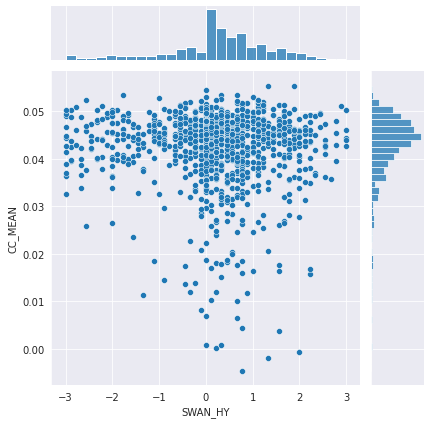

In [23]:
sns.jointplot(data=df_cc, x='SWAN_HY', y='CC_MEAN');

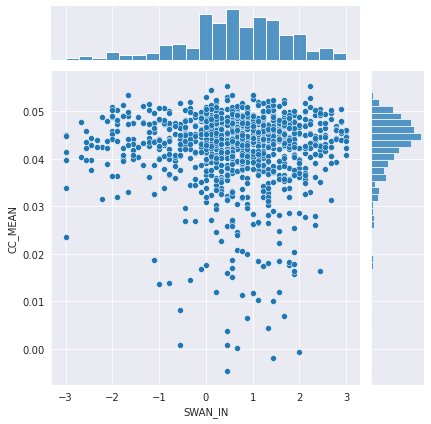

In [24]:
sns.jointplot(data=df_cc, x='SWAN_IN', y='CC_MEAN');

In [20]:
# only for merging timestamps

cc_times = []
for idx, row in df_cc.iterrows():
    df_aux = pd.read_csv(row.ET_FILE)
    #display(df_aux.start_time.index)
    #display(row.CC.index)
    index_aux = row.CC.index.astype(int)
    row.CC.set_index(index_aux, inplace=True)
    cc_times.append(((row.CC).sort_index()).merge(df_aux.start_time, how = 'left',left_index = True, right_index = True).reset_index())

In [21]:
df_cc['CC'] = pd.Series(cc_times)
df_cc['CC'].iloc[576]

,index,0,start_time
0,7,0.045563,410.163
1,9,0.054663,593.677
2,11,0.048694,760.550
3,13,0.056558,960.693
4,15,0.057001,1052.443
...,...,...,...
472,980,-0.017773,115961.886
473,982,0.060840,116203.750
474,984,0.074480,116437.378
475,986,0.000000,116804.369


Hasta aca toda la triquiñuela para acomodar los tiempos para tener las series temporales

<Figure size 792x648 with 0 Axes>

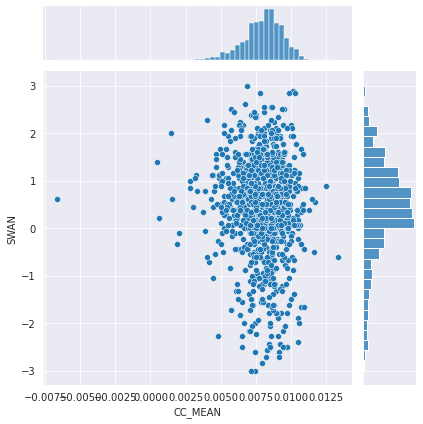

In [22]:
plt.figure(figsize=(11,9))
sns.jointplot(x='CC_MEAN',y='SWAN',data=df_cc);
# plt.savefig('figs/CC/scatter_swan_CC_video_{}.jpg'.format(vid_name))

<Figure size 792x648 with 0 Axes>

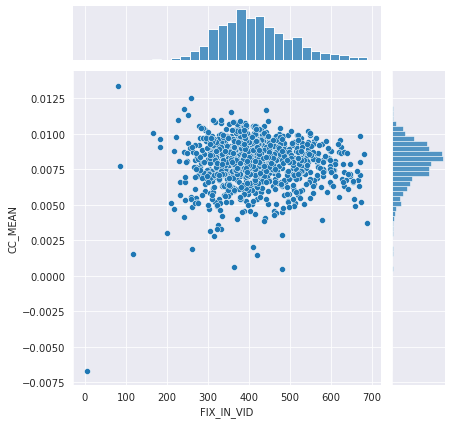

In [23]:
plt.figure(figsize=(11,9))
sns.jointplot(data=df_cc, x='FIX_IN_VID', y='CC_MEAN');
# plt.savefig('figs/CC/scatter_swan_nfix_CC_video_{}.jpg'.format(vid_name))

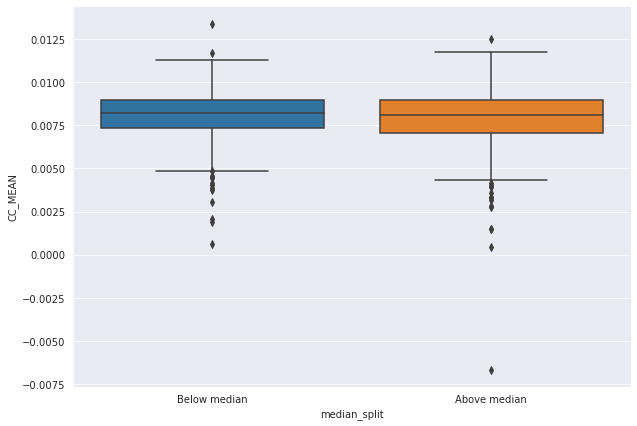

In [24]:
swan_median_bins = np.digitize(df_cc.SWAN, bins=[df_cc.SWAN.median()])
df_cc['median_split'] = swan_median_bins

fig_dims = (10, 7)
fig, ax = plt.subplots(figsize=fig_dims)
sns.boxplot(y = 'CC_MEAN', x = 'median_split', data = df_cc,ax=ax)

labels = ['Below median', 'Above median']
ax.axes.set_xticklabels(labels);

# plt.savefig('figs/CC/boxplot_CC_median_split_swan_video_{}.jpg'.format(vid_name))

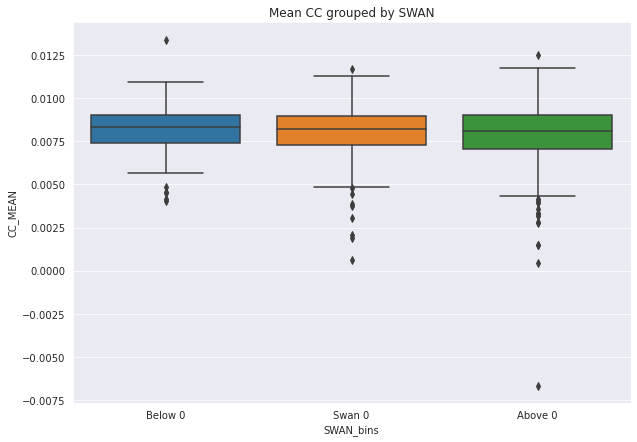

In [58]:
swan_bins = np.digitize(df_nss.SWAN,bins=[-0.51, 0.51])
labels = ['Below 0', 'Swan 0', 'Above 0']
df_cc['SWAN_bins'] = swan_bins
fig_dims = (10, 7)
fig, ax = plt.subplots(figsize=fig_dims)
sns.boxplot(y = 'CC_MEAN', x = 'SWAN_bins', data = df_cc,ax=ax);
ax.axes.set_xticklabels(labels);
ax.set_title("Mean CC grouped by SWAN");

<Figure size 792x648 with 0 Axes>

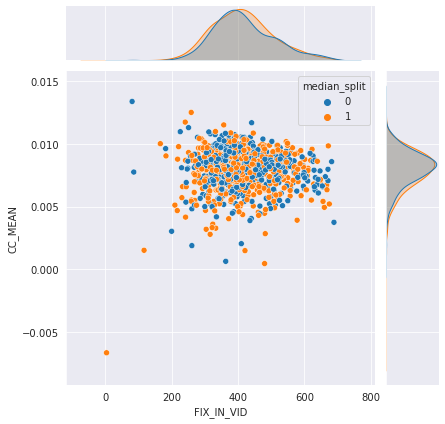

In [25]:
# pintar con edad / swan vs edad - color nss
plt.figure(figsize=(11,9))
sns.jointplot(data=df_cc, x='FIX_IN_VID', y='CC_MEAN', hue='median_split');
# plt.savefig('figs/CC/scatter_swan_nfix_CC_video_{}.jpg'.format(vid_name))

<Figure size 792x648 with 0 Axes>

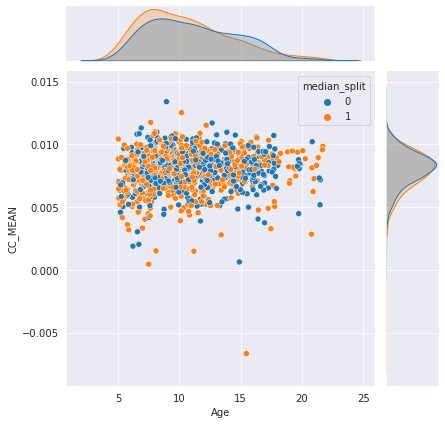

In [26]:
plt.figure(figsize=(11,9))
sns.jointplot(data=df_cc, x='Age', y='CC_MEAN', hue='median_split');
# plt.savefig('figs/CC/scatter_swan_age_CC_video_{}.jpg'.format(vid_name))

***
## NSS

In [17]:
# NSS
vid_name = 'Diary'
trials_data_vid = trials_data[trials_data.VideoName==vid_name]

# vid_saliency   = videos_data.loc[vid_name, 'VideoSaliency']
# vid_saliency_p = videos_data.loc[vid_name, 'VideoSalPercentils']
# saliency       = open_memmap('Videos_sal/cb/'+vid_saliency)
# sal_perc       = np.load('./cache/'+vid_saliency_p)

missing_folders  = []
missing_csv_vid  = []
missing_metadata = []
results_nss      = []

n_subj     = len(trials_data_vid)
subj_count = 0

for fold_subj in tqdm(os.listdir(data_path)):
    if fold_subj in list(metadata['ID'].unique()):
        pass
    else:
        missing_metadata.append(fold_subj)
        continue
        
    csv_files    = os.listdir(data_path+fold_subj)
    csv_vid_file = [f for f in csv_files if 'WK' in f]
    if len(csv_vid_file) ==0:
        missing_csv_vid.append(fold_subj)
        continue
        
    et_file      = data_path + fold_subj + '/' + csv_vid_file[0]
    df_et        = pd.read_csv(et_file)
    frame_timest = videos_data.loc[vid_name,'FramesTimestamps']
    trial_init   = trials_data.loc[fold_subj].set_index('VideoName').loc[vid_name].Start
    df_fix, flag = preprocess_fixations_new_dataset(df_et, frame_timest, trial_init)
    if flag==-1:
        continue
    else:
        nss_score = calculate_NSS(df_fix, saliency)
        nss_mean_score = np.mean(np.array(nss_score))
    
    results_nss.append((fold_subj, nss_mean_score, len(df_fix), flag, vid_name, et_file, nss_score))

  0%|          | 0/1362 [00:00<?, ?it/s]

In [18]:
df_nss = pd.DataFrame(results_nss)
df_nss.columns = ['ID', 'NSS_MEAN', 'FIX_IN_VID', 'FLAG', 'VIDEO_NAME', 'ET_FILE', 'NSS']
df_nss = pd.merge(df_nss, metadata_aux,on='ID')
df_nss.head()

,ID,NSS_MEAN,FIX_IN_VID,FLAG,VIDEO_NAME,ET_FILE,NSS,SWAN,Age
0,NDARUG492VF0,0.275558,357,0,Diary,./data/ETFinalCutSample/NDARUG492VF0/NDARUG492...,"[4.7991614, 2.705862, 1.3183514, -0.01890319, ...",-0.333333,9.506958
1,NDARJH925ZCD,0.264806,545,0,Diary,./data/ETFinalCutSample/NDARJH925ZCD/NDARJH925...,"[-0.3963129, 0.8899732, 2.1758342, 0.4855892, ...",2.888888,9.964179
2,NDARGR106TJB,0.254832,338,0,Diary,./data/ETFinalCutSample/NDARGR106TJB/NDARGR106...,"[4.16822, 4.344761, 4.622182, 2.2003243, 0.107...",NaN,19.379648
3,NDARRK135YAZ,0.293484,479,0,Diary,./data/ETFinalCutSample/NDARRK135YAZ/NDARRK135...,"[0.9909269, 0.0072297263, 0.25944558, 2.781116...",-0.444444,17.732032
4,NDARRX443NVT,0.225326,359,0,Diary,./data/ETFinalCutSample/NDARRX443NVT/NDARRX443...,"[1.0665051, 0.91483015, 5.000483, 0.08212221, ...",0.888888,12.058635


### save nss

In [19]:
# save
results_path = './results/NSS/'

df_nss.to_csv(results_path+'results_nss_swan_finegrained.csv')
df_nss.to_json(results_path+'results_nss_swan_finegrained.json')

### load nss

In [10]:
results_path = './results/NSS/'
df_nss = pd.read_json(results_path+'results_nss_swan.json')
df_nss['NSS'] = df_nss['NSS'].apply(lambda x: pd.DataFrame(x,dtype=float))

df_nss.head()

,ID,NSS_MEAN,FIX_IN_VID,FLAG,VIDEO_NAME,ET_FILE,NSS,SWAN,Age,SWAN_bins,median_split
0,NDARUG492VF0,1.611673,357,0,Diary,./data/ETFinalCutSample/NDARUG492VF0/NDARUG492...,0 0 4.027165 1 7.050632 2 ...,-0.333333,9.506958,1,0
1,NDARJH925ZCD,1.436792,545,0,Diary,./data/ETFinalCutSample/NDARJH925ZCD/NDARJH925...,0 0 -0.293100 1 0.255356 2 ...,2.888888,9.964179,2,1
2,NDARGR106TJB,0.847001,338,0,Diary,./data/ETFinalCutSample/NDARGR106TJB/NDARGR106...,0 0 5.186548 1 3.967170 2 ...,NaN,19.379648,2,1
3,NDARRK135YAZ,1.687932,479,0,Diary,./data/ETFinalCutSample/NDARRK135YAZ/NDARRK135...,0 0 0.174388 1 2.850009 2 ...,-0.444444,17.732032,1,0
4,NDARRX443NVT,1.416979,359,0,Diary,./data/ETFinalCutSample/NDARRX443NVT/NDARRX443...,0 0 0.347190 1 0.276754 2 ...,0.888888,12.058635,2,1


In [26]:
len_nss = df_nss.NSS.apply(len)

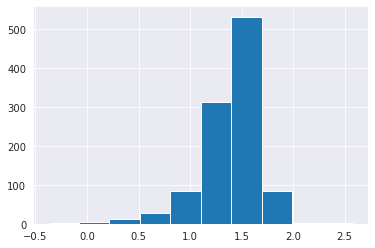

In [27]:
sns.set_style("darkgrid")
df_nss.NSS_MEAN.hist();

<Figure size 792x648 with 0 Axes>

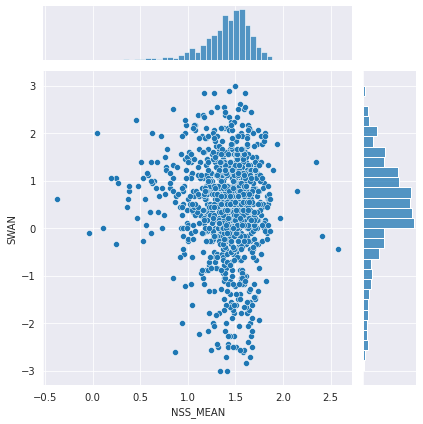

In [28]:
plt.figure(figsize=(11,9))
sns.jointplot(x='NSS_MEAN',y='SWAN',data=df_nss);
# plt.savefig('figs/NSS/scatter_swan_NSS_video_{}.jpg'.format(vid_name))

In [29]:
# load other swans
df_nss = df_nss.merge(metadata[['ID','SWAN_IN','SWAN_HY']], on='ID', how='left').dropna(axis = 0, subset=['SWAN'])
df_nss.SWAN_IN = df_nss.SWAN_IN.astype(float)
df_nss.SWAN_HY = df_nss.SWAN_HY.astype(float)

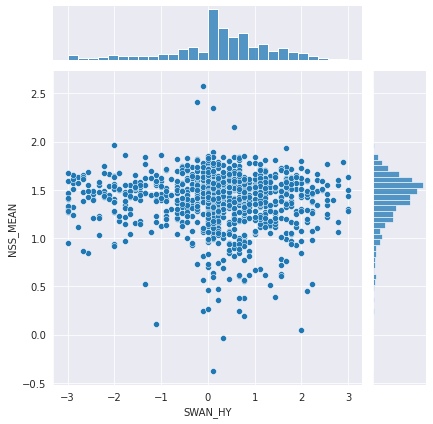

In [30]:
sns.jointplot(data=df_nss, x='SWAN_HY', y='NSS_MEAN');

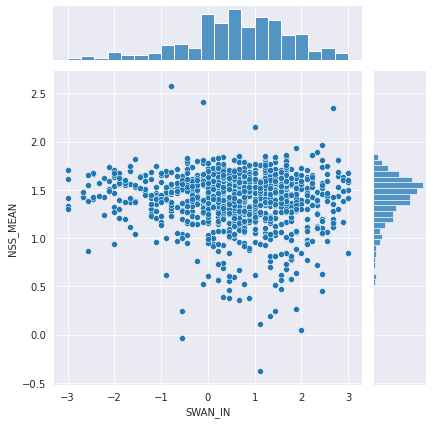

In [31]:
sns.jointplot(data=df_nss, x='SWAN_IN', y='NSS_MEAN');

<Figure size 792x648 with 0 Axes>

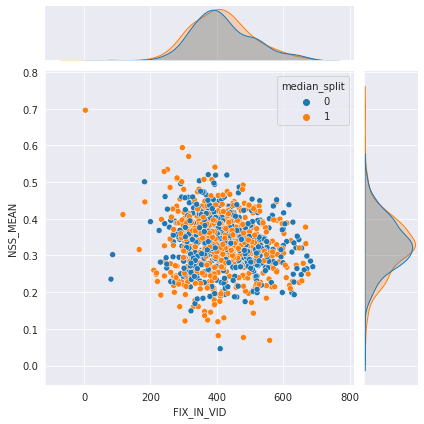

In [37]:
# pintar con edad / swan vs edad - color nss
plt.figure(figsize=(11,9));

# swan_median_bins = np.digitize(df_cc.SWAN, bins=[df_cc.SWAN.median()])
df_nss['median_split'] = swan_median_bins

# fig_dims = (10, 7);
# fig, ax = plt.subplots(figsize=fig_dims)
# sns.boxplot(y = 'CC_MEAN', x = 'median_split', data = df_nss,ax=ax)

# labels = ['Below median', 'Above median']
# ax.axes.set_xticklabels(labels);

sns.jointplot(data=df_nss, x='FIX_IN_VID', y='NSS_MEAN', hue='median_split');
# plt.savefig('figs/NSS/scatter_swan_nfix_NSS_video_{}.jpg'.format(vid_name))

<Figure size 792x648 with 0 Axes>

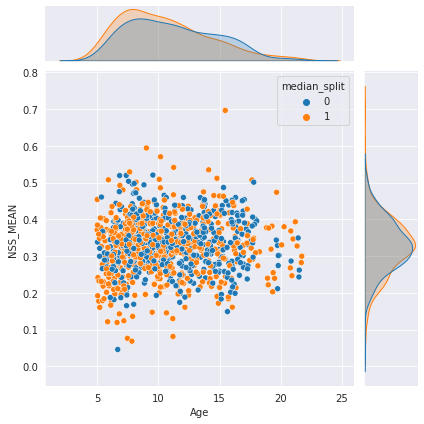

In [38]:
plt.figure(figsize=(11,9))
sns.jointplot(data=df_nss, x='Age', y='NSS_MEAN', hue='median_split');
# plt.savefig('figs/NSS/scatter_swan_age_NSS_video_{}.jpg'.format(vid_name))

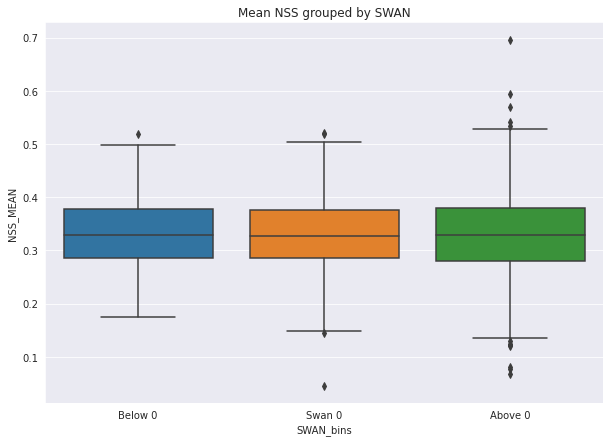

In [39]:
swan_bins = np.digitize(df_nss.SWAN,bins=[-0.51, 0.51])
labels = ['Below 0', 'Swan 0', 'Above 0']
df_nss['SWAN_bins'] = swan_bins
fig_dims = (10, 7)
fig, ax = plt.subplots(figsize=fig_dims)
sns.boxplot(y = 'NSS_MEAN', x = 'SWAN_bins', data = df_nss,ax=ax);
ax.axes.set_xticklabels(labels);
ax.set_title("Mean NSS grouped by SWAN");
# plt.savefig('figs/NSS/boxplot_swan_nss_video_{}_dropped.jpg'.format(vid_name))

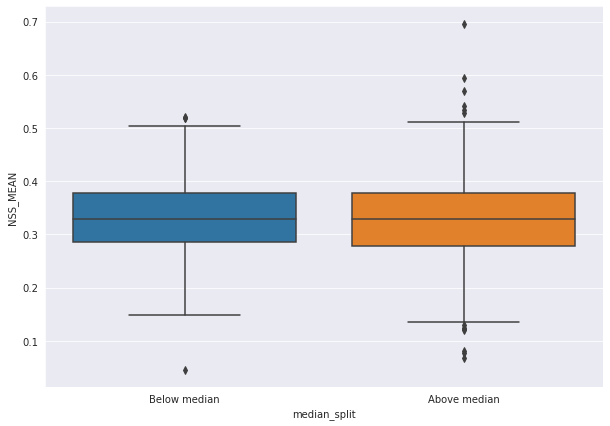

In [56]:
swan_median_bins = np.digitize(df_nss.SWAN, bins=[df_nss.SWAN.median()])
df_nss['median_split'] = swan_median_bins

fig_dims = (10, 7)
fig, ax = plt.subplots(figsize=fig_dims)
sns.boxplot(y = 'NSS_MEAN', x = 'median_split', data = df_nss,ax=ax)

labels = ['Below median', 'Above median']
ax.axes.set_xticklabels(labels);

# plt.savefig('figs/NSS/boxplot_NSS_median_split_swan_video_{}.jpg'.format(vid_name))

In [40]:
from scipy.stats import ttest_ind

nss_below = df_nss[df_nss['median_split']==0]
nss_below = nss_below[nss_below['SWAN'].notna()]
print(nss_below.shape[0])
nss_above = df_nss[df_nss['median_split']==1]
nss_above = nss_above[nss_above['SWAN'].notna()]
print(nss_above.shape[0])

ttest_ind(nss_above['SWAN'], nss_below['SWAN'], equal_var=False)

504
521


Ttest_indResult(statistic=36.18048047356349, pvalue=2.417647879552666e-176)

****

## save exploded csv

In [41]:
def explode(frame, columns):
    """
    This helper function explodes a new row
        for each value in an array of values.
    If there is more than one column to be exploded,
        the array lengths must be the same (row-wise)
    (Adapted from a SE code snippet)
    Args:
        frame: The input dataframe
        columns: the columns with arrays to explode
    Returns:
        transformed dataframe
    """
    # all columns that are not arrays of values
    idx_cols = frame.columns.difference(columns)

    # calculate lengths of arrays
    lens = frame[columns[0]].str.len()

    return pd.DataFrame({
        col: np.repeat(frame[col].values, lens)
        for col in idx_cols
    }).assign(**{col: np.concatenate(frame[col].values)
                 for col in columns}).loc[:, frame.columns]

In [44]:
df_cc2=df_cc.copy()
df_nss2=df_nss.copy()

In [45]:
df_cc2['CC_val'] = df_cc2['CC'].apply(lambda x: x.iloc[:,1].to_list())
df_cc2['FIX_ts'] = df_cc2['CC'].apply(lambda x: x.iloc[:,2].to_list())
df_cc2['FIX_idx'] = df_cc2['CC'].apply(lambda x: x.iloc[:,0].to_list())

In [46]:
results_path ='./results/NSS/'
# df_nss2 = pd.read_json(results_path+'results_nss_swan.json')
df_final = pd.concat([df_cc2,df_nss2[['NSS_MEAN','NSS']]], axis=1)
df_final=df_final.rename(columns = {'NSS':'NSS_val'})
df_final.head(2)

,ID,CC,FIX_IN_VID,FLAG,VIDEO_NAME,ET_FILE,SWAN,Age,CC_MEAN,median_split,CC_val,FIX_ts,FIX_idx,NSS_MEAN,NSS_val
0,NDARUG492VF0,index 0 start_time 0 1 0...,357,0,Diary,./data/ETFinalCutSample/NDARUG492VF0/NDARUG492...,-0.333333,9.506958,0.009876,0,"[0.05425828412727631, 0.05680557230244678, 0.0...","[328.089000000153, 544.679000000004, 794.57400...","[1, 3, 5, 8, 10, 12, 14, 16, 18, 20, 22, 24, 2...",0.275558,"[4.7991614, 2.705862, 1.3183514, -0.01890319, ..."
1,NDARJH925ZCD,index 0 start_time 0 5 -0...,545,0,Diary,./data/ETFinalCutSample/NDARJH925ZCD/NDARJH925...,2.888888,9.964179,0.010195,1,"[-0.019697046484441025, 0.04630408844696807, 0...","[254.45299999998, 454.385000000009, 704.297999...","[5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, ...",0.264806,"[-0.3963129, 0.8899732, 2.1758342, 0.4855892, ..."


In [47]:
results_path = 'results/'
df_final2 = explode(df_final, ['FIX_ts','FIX_idx','CC_val','NSS_val']).drop(columns='CC')
# df_final2.to_csv(results_path+'results_all_s03_diary_exploded.csv')

In [48]:
df_final2.head()

,ID,FIX_IN_VID,FLAG,VIDEO_NAME,ET_FILE,SWAN,Age,CC_MEAN,median_split,CC_val,FIX_ts,FIX_idx,NSS_MEAN,NSS_val
0,NDARUG492VF0,357,0,Diary,./data/ETFinalCutSample/NDARUG492VF0/NDARUG492...,-0.333333,9.506958,0.009876,0,0.054258,328.089,1,0.275558,4.799161
1,NDARUG492VF0,357,0,Diary,./data/ETFinalCutSample/NDARUG492VF0/NDARUG492...,-0.333333,9.506958,0.009876,0,0.056806,544.679,3,0.275558,2.705862
2,NDARUG492VF0,357,0,Diary,./data/ETFinalCutSample/NDARUG492VF0/NDARUG492...,-0.333333,9.506958,0.009876,0,0.036780,794.574,5,0.275558,1.318351
3,NDARUG492VF0,357,0,Diary,./data/ETFinalCutSample/NDARUG492VF0/NDARUG492...,-0.333333,9.506958,0.009876,0,0.043314,1494.299,8,0.275558,-0.018903
4,NDARUG492VF0,357,0,Diary,./data/ETFinalCutSample/NDARUG492VF0/NDARUG492...,-0.333333,9.506958,0.009876,0,0.042812,1594.258,10,0.275558,0.964498


### load explode

In [50]:
# if alredy loaded
df_exploded = df_final2.copy()

In [9]:
results_path = 'results/'
df_exploded = pd.read_csv('results/results_all_s03_diary_exploded.csv')
df_exploded.head()

,Unnamed: 0,ID,FIX_IN_VID,FLAG,VIDEO_NAME,ET_FILE,SWAN,Age,CC_MEAN,CC_val,FIX_ts,FIX_idx,NSS_MEAN,NSS_val
0,0,NDARUG492VF0,357,0,Diary,./data/ETFinalCutSample/NDARUG492VF0/NDARUG492...,-0.333333,9.506958,0.048263,0.097183,328.089,1,1.611673,4.027165
1,1,NDARUG492VF0,357,0,Diary,./data/ETFinalCutSample/NDARUG492VF0/NDARUG492...,-0.333333,9.506958,0.048263,0.101037,544.679,3,1.611673,7.050632
2,2,NDARUG492VF0,357,0,Diary,./data/ETFinalCutSample/NDARUG492VF0/NDARUG492...,-0.333333,9.506958,0.048263,0.031186,794.574,5,1.611673,1.138369
3,3,NDARUG492VF0,357,0,Diary,./data/ETFinalCutSample/NDARUG492VF0/NDARUG492...,-0.333333,9.506958,0.048263,0.003715,1494.299,8,1.611673,-0.225604
4,4,NDARUG492VF0,357,0,Diary,./data/ETFinalCutSample/NDARUG492VF0/NDARUG492...,-0.333333,9.506958,0.048263,0.017125,1594.258,10,1.611673,0.906723


In [56]:
trials_data

FilePath  \
ID           Video_ID                                                      
NDARAA075AMK Video1    /Volumes/methlab_data/HBN/EEG-ET/NDARAA075AMK/...   
             Video3    /Volumes/methlab_data/HBN/EEG-ET/NDARAA075AMK/...   
NDARAA117NEJ Video1    /Volumes/methlab_data/HBN/EEG-ET/NDARAA117NEJ/...   
             Video3    /Volumes/methlab_data/HBN/EEG-ET/NDARAA117NEJ/...   
NDARAA306NT2 Video-DM  /Volumes/methlab_data/HBN/EEG-ET/NDARAA306NT2/...   
...                                                                  ...   
NDARZZ830JM7 Video-TP  /Volumes/methlab_data/HBN/EEG-ET/NDARZZ830JM7/...   
             Video-WK  /Volumes/methlab_data/HBN/EEG-ET/NDARZZ830JM7/...   
NDARZZ993CEV Video-DM  /Volumes/methlab_data/HBN/EEG-ET/NDARZZ993CEV/...   
             Video-TP  /Volumes/methlab_data/HBN/EEG-ET/NDARZZ993CEV/...   
             Video-WK  /Volumes/methlab_data/HBN/EEG-ET/NDARZZ993CEV/...   

                        VideoName  SRate       Start          Stop  \
ID           Video_ID                                                
NDARAA075AMK Video1         Diary     60  2887191440  3.004585e+09   
             Video3    Despicable     60  3788400246  3.958946e+09   
NDARAA117NEJ Video1         Diary     60  3333897971  3.451293e+09   
             Video3    Despicable     60  4710198376  4.880739e+09   
NDARAA306NT2 Video-DM  Despicable     60  3125258026  3.295796e+09   
...                           ...    ...         ...           ...   
NDARZZ830JM7 Video-TP     Present    120  4628693960  4.831761e+09   
             Video-WK       Diary    120  2873024513  2.990411e+09   
NDARZZ993CEV Video-DM  Despicable     30  2863666226  3.034200e+09   
             Video-TP     Present     30  3352926958  3.556191e+09   
             Video-WK       Diary     30  1681348179  1.798746e+09   

                          Duration  
ID           Video_ID               
NDARAA075AMK Video1    117393138.0  
             Video3    170545550.0  
NDARAA117NEJ Video1    117395130.0  
             Video3    170540748.0  
NDARAA306NT2 Video-DM  170537702.0  
...                            ...  
NDARZZ830JM7 Video-TP  203067108.0  
             Video-WK  117386375.0  
NDARZZ993CEV Video-DM  170534179.0  
             Video-TP  203264235.0  
             Video-WK  117397730.0  

[8290 rows x 6 columns]

In [51]:
dfs_list = []
for idx in df_exploded.ID.unique():
    
    df_aux       = df_exploded[df_exploded.ID==idx].copy()
    et_file      = df_aux.ET_FILE.iloc[0]
    df_et        = pd.read_csv(et_file)
    frame_timest = videos_data.loc[vid_name,'FramesTimestamps']
    trial_init   = trials_data.loc[fold_subj].set_index('VideoName').loc[vid_name].Start
    df_fix, flag = preprocess_fixations_new_dataset(df_et, frame_timest, trial_init)
    frame_id     = df_fix.frames_seen.apply(lambda x: x[0])
    df_aux       = df_aux.merge(frame_id,how='outer',left_on='FIX_idx',right_index=True)    
    dfs_list.append(df_aux)    

In [53]:
df_exploded_frames = pd.concat(dfs_list)
df_exploded_frames.rename({'frames_seen':'FRAME_idx'}, axis=1, inplace=True)
# df_exploded_frames.drop(columns=['Unnamed: 0'], inplace= True)
df_exploded_frames.head()

,ID,FIX_IN_VID,FLAG,VIDEO_NAME,ET_FILE,SWAN,Age,CC_MEAN,median_split,CC_val,FIX_ts,FIX_idx,NSS_MEAN,NSS_val,FRAME_idx
0,NDARUG492VF0,357,0,Diary,./data/ETFinalCutSample/NDARUG492VF0/NDARUG492...,-0.333333,9.506958,0.009876,0,0.054258,328.089,1,0.275558,4.799161,8
1,NDARUG492VF0,357,0,Diary,./data/ETFinalCutSample/NDARUG492VF0/NDARUG492...,-0.333333,9.506958,0.009876,0,0.056806,544.679,3,0.275558,2.705862,14
2,NDARUG492VF0,357,0,Diary,./data/ETFinalCutSample/NDARUG492VF0/NDARUG492...,-0.333333,9.506958,0.009876,0,0.036780,794.574,5,0.275558,1.318351,20
3,NDARUG492VF0,357,0,Diary,./data/ETFinalCutSample/NDARUG492VF0/NDARUG492...,-0.333333,9.506958,0.009876,0,0.043314,1494.299,8,0.275558,-0.018903,36
4,NDARUG492VF0,357,0,Diary,./data/ETFinalCutSample/NDARUG492VF0/NDARUG492...,-0.333333,9.506958,0.009876,0,0.042812,1594.258,10,0.275558,0.964498,39


### save exploded with frame indexing

In [8]:
exploded_file = 'results/results_all_s03_diary_exploded.csv'
df_exploded_frames.to_csv(exploded_file, index=False)

NameError: name 'df_exploded_frames' is not defined

In [55]:
# loading only for sanity check
df_check = pd.read_csv(exploded_file)
df_check.head()

,ID,FIX_IN_VID,FLAG,VIDEO_NAME,ET_FILE,SWAN,Age,CC_MEAN,median_split,CC_val,FIX_ts,FIX_idx,NSS_MEAN,NSS_val,FRAME_idx
0,NDARUG492VF0,357,0,Diary,./data/ETFinalCutSample/NDARUG492VF0/NDARUG492...,-0.333333,9.506958,0.009876,0,0.054258,328.089,1,0.275558,4.799161,8
1,NDARUG492VF0,357,0,Diary,./data/ETFinalCutSample/NDARUG492VF0/NDARUG492...,-0.333333,9.506958,0.009876,0,0.056806,544.679,3,0.275558,2.705862,14
2,NDARUG492VF0,357,0,Diary,./data/ETFinalCutSample/NDARUG492VF0/NDARUG492...,-0.333333,9.506958,0.009876,0,0.036780,794.574,5,0.275558,1.318351,20
3,NDARUG492VF0,357,0,Diary,./data/ETFinalCutSample/NDARUG492VF0/NDARUG492...,-0.333333,9.506958,0.009876,0,0.043314,1494.299,8,0.275558,-0.018903,36
4,NDARUG492VF0,357,0,Diary,./data/ETFinalCutSample/NDARUG492VF0/NDARUG492...,-0.333333,9.506958,0.009876,0,0.042812,1594.258,10,0.275558,0.964498,39
